All the imports

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder


First read data from train.csv

In [2]:
long = pd.read_csv("train.csv")
long.head(10)

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750
5,ID1012260530__Dry_Clover_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Clover_g,0.0000
6,ID1012260530__Dry_Dead_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Dead_g,0.0000
7,ID1012260530__Dry_Green_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Green_g,7.6000
8,ID1012260530__Dry_Total_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Total_g,7.6000
9,ID1012260530__GDM_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,GDM_g,7.6000


Convert data from long to wide format

In [3]:
long["image_id"] = long["sample_id"].str.split("__").str[0]

wide = long.pivot_table(
    index=['image_id', 'image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm'],
    columns='target_name',
    values='target'
).reset_index()

wide.columns.name = None
wide = wide.rename_axis(None, axis=1)

targets = ["Dry_Green_g","Dry_Dead_g","Dry_Clover_g","GDM_g","Dry_Total_g"]

print("Rows (images):", wide.shape[0])
print("Columns:", wide.columns.tolist())
wide.head(10)


Rows (images): 357
Columns: ['image_id', 'image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']


,image_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,ID1011485656,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,0.0000,31.9984,16.2751,48.2735,16.2750
1,ID1012260530,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,0.0000,0.0000,7.6000,7.6000,7.6000
2,ID1025234388,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.38,1.0000,6.0500,0.0000,0.0000,6.0500,6.0500
3,ID1028611175,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,0.66,5.0000,0.0000,30.9703,24.2376,55.2079,24.2376
4,ID1035947949,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,0.54,3.5000,0.4343,23.2239,10.5261,34.1844,10.9605
5,ID1036339023,train/ID1036339023.jpg,2015/9/30,Vic,Phalaris_Clover,0.82,7.0000,23.0755,2.6135,32.1910,57.8800,55.2665
6,ID1049634115,train/ID1049634115.jpg,2015/7/2,Vic,Ryegrass_Clover,0.72,2.0000,1.5083,3.0167,13.5750,18.1000,15.0833
7,ID1051144034,train/ID1051144034.jpg,2015/9/1,WA,SubcloverLosa,0.80,1.0000,55.3200,0.0000,0.0000,55.3200,55.3200
8,ID1052620238,train/ID1052620238.jpg,2015/5/18,Tas,Ryegrass,0.68,5.0000,0.0000,11.2291,20.1707,31.3998,20.1707
9,ID105271783,train/ID105271783.jpg,2015/6/30,Vic,Phalaris_Clover,0.86,4.0000,5.2698,8.5635,27.6667,41.5000,32.9365


Analyse the data

Total images: 357
Missing values per column:
 image_id         0
image_path       0
Sampling_Date    0
State            0
Species          0
Pre_GSHH_NDVI    0
Height_Ave_cm    0
Dry_Clover_g     0
Dry_Dead_g       0
Dry_Green_g      0
Dry_Total_g      0
GDM_g            0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Dry_Green_g,357.0,26.624722,25.401232,0.00,8.8000,20.8000,35.0834,157.9836
Dry_Dead_g,357.0,12.044548,12.402007,0.00,3.2000,7.9809,17.6378,83.8407
Dry_Clover_g,357.0,6.649692,12.117761,0.00,0.0000,1.4235,7.2429,71.7865
GDM_g,357.0,33.274414,24.935822,1.04,16.0261,27.1082,43.6757,157.9836
Dry_Total_g,357.0,45.318097,27.984015,1.04,25.2715,40.3000,57.8800,185.7000


Species
Phalaris                                                       100.262500
Fescue                                                          86.317857
Phalaris_Clover_Ryegrass_Barleygrass_Bromegrass                 55.557143
Lucerne                                                         54.654545
Phalaris_Clover                                                 51.409286
Mixed                                                           47.563000
Fescue_CrumbWeed                                                46.550000
Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed     39.663636
Ryegrass_Clover                                                 38.889031
Ryegrass                                                        37.503361
Name: Dry_Total_g, dtype: float64


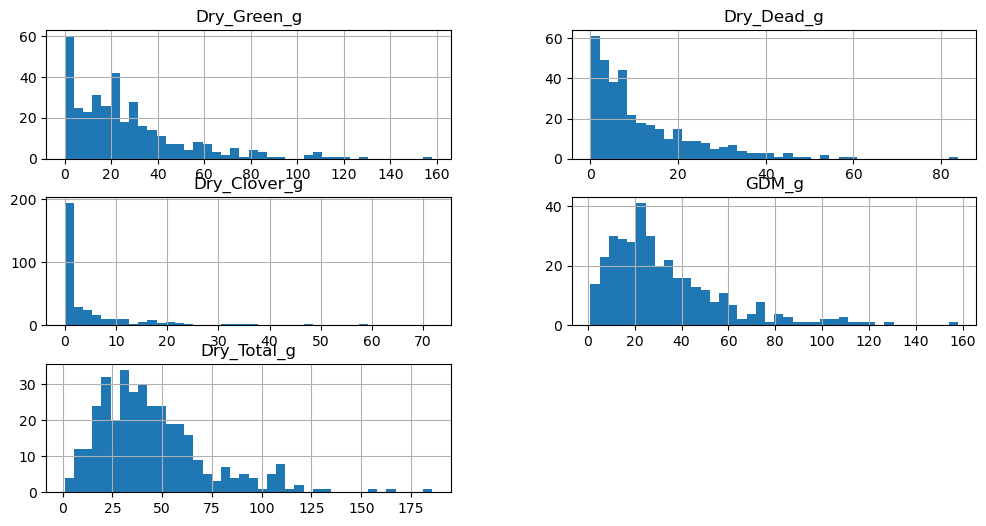

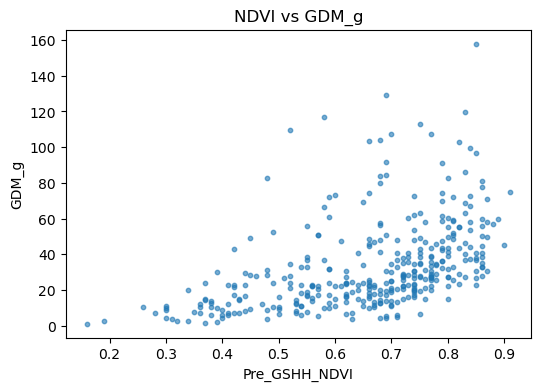

In [4]:
print("Total images:", len(wide))
print("Missing values per column:\n", wide.isna().sum())

display(wide[targets].describe().T)

_ = wide[targets].hist(bins=40, figsize=(12,6))

plt.figure(figsize=(6,4))
plt.scatter(wide['Pre_GSHH_NDVI'].astype(float), wide['GDM_g'], alpha=0.6, s=10)
plt.xlabel('Pre_GSHH_NDVI'); plt.ylabel('GDM_g'); plt.title('NDVI vs GDM_g')

print(wide.groupby('Species')['Dry_Total_g'].mean().sort_values(ascending=False).head(10))

In [5]:
try:
    import cv2
    have_cv2 = True
except Exception:
    have_cv2 = False

def extract_basic_img_feats(full_img_path, downscale=(500,250)):
    """
    Returns a dict of simple image features. Full path must exist.
    downscale: max width/height to speed up feature extraction.
    """
    im = Image.open(full_img_path).convert("RGB")
    im.thumbnail(downscale)
    arr = np.asarray(im)/255.0
    
    mean_rgb = arr.mean(axis=(0,1))
    std_rgb = arr.std(axis=(0,1))
    green_ratio = mean_rgb[1] / (mean_rgb.sum() + 1e-9)
    
    if have_cv2:
        hsv = cv2.cvtColor((arr*255).astype(np.uint8), cv2.COLOR_RGB2HSV)
        brightness = hsv[:,:,2].mean()/255
        saturation = hsv[:,:,1].mean()/255
        gray = (0.2989*arr[:,:,0] + 0.587*arr[:,:,1] + 0.114*arr[:,:,2])
        lap_var = cv2.Laplacian((gray*255).astype(np.uint8), cv2.CV_64F).var()
    else:
        maxc = arr.max(axis=2)
        minc = arr.min(axis=2)
        brightness = maxc.mean()
        saturation = ((maxc-minc)/(maxc+1e-9)).mean()
        gray = (0.2989*arr[:,:,0] + 0.587*arr[:,:,1] + 0.114*arr[:,:,2])
        gy, gx = np.gradient(gray)
        lap_var = np.var(np.sqrt(gx*gx + gy*gy))
    
    return {
        "meanR": mean_rgb[0], "meanG": mean_rgb[1], "meanB": mean_rgb[2],
        "stdR": std_rgb[0], "stdG": std_rgb[1], "stdB": std_rgb[2],
        "green_ratio": green_ratio,
        "brightness": brightness, "saturation": saturation,
        "lap_var": lap_var
    }

# Loop through all train images
rows = []
for p in tqdm(wide['image_path'].unique(), desc="Extracting image features"):
    feats = extract_basic_img_feats(p)
    feats['image_id'] = os.path.basename(p).split('.')[0]
    rows.append(feats)

img_feats_df = pd.DataFrame(rows)
img_feats_df.to_csv("image_features.csv", index=False)
print("Saved image_features.csv")


Extracting image features:   0%|          | 0/357 [00:00<?, ?it/s]

Saved image_features.csv


In [6]:
# ---- Load your extracted image features ----
img_feats = pd.read_csv("image_features.csv")

print("wide:", wide.shape)
print("img_feats:", img_feats.shape)

# ---- Merge on image_id ----
merged = wide.merge(img_feats, on="image_id", how="left")

print("merged:", merged.shape)

# Check for missing features
print("Missing feature rows:", merged["meanR"].isna().sum())

# Save the merged training dataset
merged.to_csv("training_table.csv", index=False)
print("Saved training_table.csv")


wide: (357, 12)
img_feats: (357, 11)
merged: (357, 22)
Missing feature rows: 0
Saved training_table.csv


In [8]:
df = pd.read_csv("training_table.csv")
print(df.columns)

Index(['image_id', 'image_path', 'Sampling_Date', 'State', 'Species',
       'Pre_GSHH_NDVI', 'Height_Ave_cm', 'Dry_Clover_g', 'Dry_Dead_g',
       'Dry_Green_g', 'Dry_Total_g', 'GDM_g', 'meanR', 'meanG', 'meanB',
       'stdR', 'stdG', 'stdB', 'green_ratio', 'brightness', 'saturation',
       'lap_var'],
      dtype='object')


In [12]:
# ------------------------------------
# 1. Load training table
# ------------------------------------
df = pd.read_csv("training_table.csv")
print(df.shape)
print(df.head())

# ------------------------------------
# 2. Define target columns
# ------------------------------------
target_cols = ["Dry_Clover_g","Dry_Dead_g","Dry_Green_g","Dry_Total_g","GDM_g"]

# ------------------------------------
# 3. Process categorical metadata
# ------------------------------------
cat_cols = ["State", "Species"]

encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_cats = encoder.fit_transform(df[cat_cols])

cat_feature_names = encoder.get_feature_names_out(cat_cols)

df_cat = pd.DataFrame(encoded_cats, columns=cat_feature_names)

# ------------------------------------
# 4. Build final feature table
# ------------------------------------
numeric_cols = [
    c for c in df.columns
    if c not in ["image_id","image_path","Sampling_Date"] + cat_cols + target_cols
]

df_num = df[numeric_cols].reset_index(drop=True)

X = pd.concat([df_num, df_cat], axis=1)
print("Final feature matrix shape:", X.shape)

# ------------------------------------
# 5. Weighted R² metric
# ------------------------------------
def weighted_r2(y_true, y_pred):
    mean_y = y_true.mean()
    weights = 1.0 / (mean_y + 1e-9)
    num = np.sum(weights * (y_true - y_pred)**2)
    den = np.sum(weights * (y_true - mean_y)**2)
    return 1 - num/den

# ------------------------------------
# 6. 5-fold CV training (per target)
# ------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}
models = {}

for target in target_cols:
    print(f"\nTraining model for target: {target}")
    
    y = df[target].values
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = LGBMRegressor(
            n_estimators=500,
            learning_rate=0.03,
            max_depth=6,
            num_leaves=31,
            min_data_in_leaf=10,
            min_gain_to_split=0.001,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        score = weighted_r2(y_val, preds)
        fold_scores.append(score)

        print(f"  Fold {fold}: R² = {score:.4f}")

    avg_score = np.mean(fold_scores)
    results[target] = avg_score
    print(f"Mean CV R² for {target}: {avg_score:.4f}")

    # Train final model on full data
    final_model = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.03,
        num_leaves=64
    )
    final_model.fit(X, y)
    models[target] = final_model

# ------------------------------------
# 7. Print all scores
# ------------------------------------
print("\n==== Baseline LightGBM Results ====")
for t, v in results.items():
    print(f"{t}: {v:.4f}")


(357, 22)
       image_id              image_path Sampling_Date State  \
0  ID1011485656  train/ID1011485656.jpg      2015/9/4   Tas   
1  ID1012260530  train/ID1012260530.jpg      2015/4/1   NSW   
2  ID1025234388  train/ID1025234388.jpg      2015/9/1    WA   
3  ID1028611175  train/ID1028611175.jpg     2015/5/18   Tas   
4  ID1035947949  train/ID1035947949.jpg     2015/9/11   Tas   

             Species  Pre_GSHH_NDVI  Height_Ave_cm  Dry_Clover_g  Dry_Dead_g  \
0    Ryegrass_Clover           0.62         4.6667        0.0000     31.9984   
1            Lucerne           0.55        16.0000        0.0000      0.0000   
2  SubcloverDalkeith           0.38         1.0000        6.0500      0.0000   
3           Ryegrass           0.66         5.0000        0.0000     30.9703   
4           Ryegrass           0.54         3.5000        0.4343     23.2239   

   Dry_Green_g  ...     meanR     meanG     meanB      stdR      stdG  \
0      16.2751  ...  0.428769  0.466437  0.330696  0.2128

In [14]:
wide.head()

,image_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,ID1011485656,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,0.0000,31.9984,16.2751,48.2735,16.2750
1,ID1012260530,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,0.0000,0.0000,7.6000,7.6000,7.6000
2,ID1025234388,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.38,1.0000,6.0500,0.0000,0.0000,6.0500,6.0500
3,ID1028611175,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,0.66,5.0000,0.0000,30.9703,24.2376,55.2079,24.2376
4,ID1035947949,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,0.54,3.5000,0.4343,23.2239,10.5261,34.1844,10.9605


In [15]:
train.head()

NameError: name 'train' is not defined